# Emotional Text Analysis
## Statistical text analysis for emotional extraction and some generalizations
#### Alberto Barradas
[@abcsds](http://github.com/abcsds)

## Emotion, and behaviour.

There are several theories of emotion, all indicate that emotions are a precursor of behaviour.

## Models of Emotion

### Affect
Most used model for text analysis. Maps into 2D plane. Cannot map back into emotions.
![](img/Circumplex.jpg)

### Bio-chemical
Very precise, closest to biochemical definition of emotions. Not practical.
![](img/Loevheim.png)

### Ekman's model of emotion
Widely used in face recognition programs. Widely accepted. Requires face-recognition software, thus very costly.
![](img/Ekman.jpg)

### Functional
Based on etological observations. Superset of Ekman's model.
![](img/Plutchik.png)
http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

### The dictionary

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
emotions = ["anger",
            "anticipation",
            "disgust",
            "fear",
            "joy",
            "negative",
            "positive",
            "sadness",
            "surprise",
            "trust"]
df = pd.read_csv("dict.csv")
df.head(10)

,Word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0
5,abate,0,0,0,0,0,0,0,0,0,0
6,abatement,0,0,0,0,0,0,0,0,0,0
7,abba,0,0,0,0,0,0,1,0,0,0
8,abbot,0,0,0,0,0,0,0,0,0,1
9,abbreviate,0,0,0,0,0,0,0,0,0,0


In [3]:
df[emotions].sum()

anger           1247
anticipation     839
disgust         1058
fear            1476
joy              689
negative        3324
positive        2312
sadness         1191
surprise         534
trust           1231
dtype: int64

In [15]:
print(len(df))
df[emotions].sum()/len(df)*100

14181


anger            8.793456
anticipation     5.916367
disgust          7.460687
fear            10.408293
joy              4.858614
negative        23.439814
positive        16.303505
sadness          8.398561
surprise         3.765602
trust            8.680629
dtype: float64

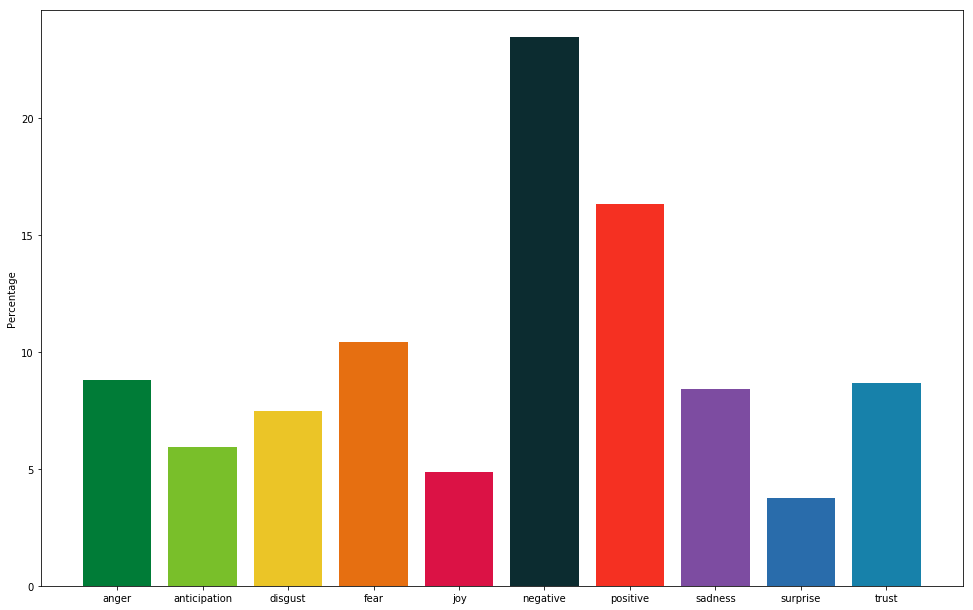

In [30]:
fig = plt.figure(figsize=(16, 10))
y_pos = np.arange(len(emotions))
percentage = df[emotions].sum()/len(df)*100
percentage = percentage.tolist()

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
colors = ["#007C37","#79BF2A","#EBC527","#E66F11","#DB1245","#0C2C30","#F53022","#7D4CA1","#296CAB","#1781AA"]
bars = ax.bar(y_pos, percentage, align='center')
for bar,c in zip(bars,colors):
    bar.set_facecolor(c)

plt.xticks(y_pos, emotions)
plt.ylabel('Percentage')


### Applying it
Using tweepy for twitter acces, but can be done with any text. http://www.tweepy.org/

Tools used:
- Tweepy listener for extracting twitter data.
- Tweepy Stream and OauthHandler class for conectivity
- Python's json library for extracting text from tweets
- A csv to python-dictionary reader from the csv library
- Seaborn for visualizations https://seaborn.pydata.org/

In [31]:
from tweepy.streaming import StreamListener
from tweepy import Stream
from tweepy import OAuthHandler

import json
from csv import DictReader
import seaborn as sns

#### Hidden keys :)
Access twitter with OAuth. https://dev.twitter.com/oauth/overview/application-owner-access-tokens

In [32]:
import myKeys

api_key = myKeys.api_key
api_secret = myKeys.api_secret
access_token_key = myKeys.access_token_key
access_token_secret = myKeys.access_token_secret

Read the csv into a python dictionary

In [33]:
cols = ['anger', 'anticipation', 'disgust', 'fear',
        'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

dictFile  = 'dict.csv'
mainDict = {}
with open(dictFile) as csvFile:
        reader = DictReader(csvFile)
        for row in reader:
            mainDict[row['Word']] = [int(row[i]) for i in cols]

#### Create a tweepy listener
The StreamListener class can be used to handle the incoming tweets. Here every tweet will be given an emotional score in the shape of a 10-valued vector.

In [34]:
class ColorListener(StreamListener):

    def __init__(self):
        self.tweets = pd.DataFrame(columns=('tweet', 'anger', 'anticipation',
                'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'))

    def on_data(self, data):
        try:
            tweet = json.loads(data)
            vector = self.score(tweet)
            print(vector)
            row = pd.Series([tweet['text']]+vector, index=['tweet', 'anger', 'anticipation',
                'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'])
            self.tweets = self.tweets.append(row, ignore_index=True)
        except UnboundLocalError:
            raise UnboundLocalError # Tweet doesn't have text
        except:
            pass
        return True

    def score(self, tweet):
        line = tweet['text'].replace('.','').replace(',','').replace(';','').replace(':','').replace('\t',' ').replace('\n',' ')
        words = line.split(' ')
        score = [0] * 10
        for word in words:
            if word in mainDict:
                for i in range(len(score)):
                    score[i] += mainDict[word][i]
        return score

    def on_error(self, status):
        print("Error: ", status)

Let's run it:
We can pick other listening filters.

In [35]:
cListener = ColorListener()
auth = OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token_key, access_token_secret)

stream = Stream(auth, cListener)

# Start reading stream for english tweets with the color words
stream.filter(languages=['en'], track=['red', 'green','blue'])
# stream.filter(languages=['en'], track=['trump'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 2, 0, 3, 0, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 1, 2, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
[1, 0, 1, 1, 0, 2, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 2, 0, 2, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0

[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 2, 0, 2, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 2, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 1, 1, 1, 1, 0, 2]
[1, 0, 0, 1, 0, 2, 1, 2, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 1, 0, 0, 3, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 1, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]
[0, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 2, 0, 2, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
[0, 2, 0, 0, 1, 0, 2, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 0, 1, 0, 1, 1]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 3, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 0, 0, 2, 0, 2, 1, 1, 3]
[0, 1, 0, 0, 1, 0, 1, 1, 0, 1]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 1, 0, 0, 2, 0, 2, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 0, 0

[1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 1, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2, 0, 1, 2, 1, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 2, 0, 2, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 2, 0, 2, 1, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 2, 0, 1, 2]
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 1, 0, 2, 0, 2, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[2, 2, 0, 1, 3, 0, 4, 0, 1, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0

KeyboardInterrupt: 

In [36]:
df = cListener.tweets
print(len(df.index)) # Number of rows

1548


In [37]:
df.head(10) # How the data looks like

,tweet,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,Vote 4 John H Cox 4 #CAGov Lets turn CA all RE...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,RT @Petunia5SOS: hitting\nevery\nred\nlight\nk...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,2.0
2,RT @DarrenCriss: So what's more red? My sunbur...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,RT @Panthers: First look at @CMcCaffrey5 in bl...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
4,Starting Friday June 30- July 4th we will be r...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,RT @ncaprio: Please @GameOfThrones get @zane a...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,@Ntshuxi_Masingi Lol blue?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,RT @ncaprio: Please @GameOfThrones get @zane a...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,@camilluddington i hope we get a scene of jole...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0
9,RT @Simpboyz: he took gucci manes jacket and a...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


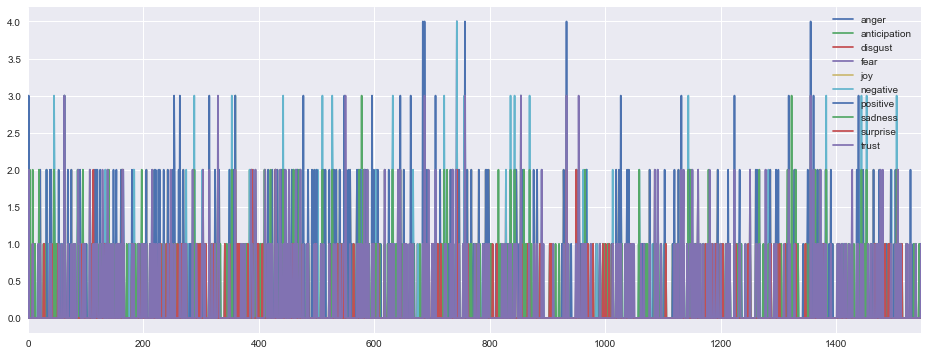

In [38]:
df.plot(figsize=(16, 6)) # Plot the sentiment as a time series

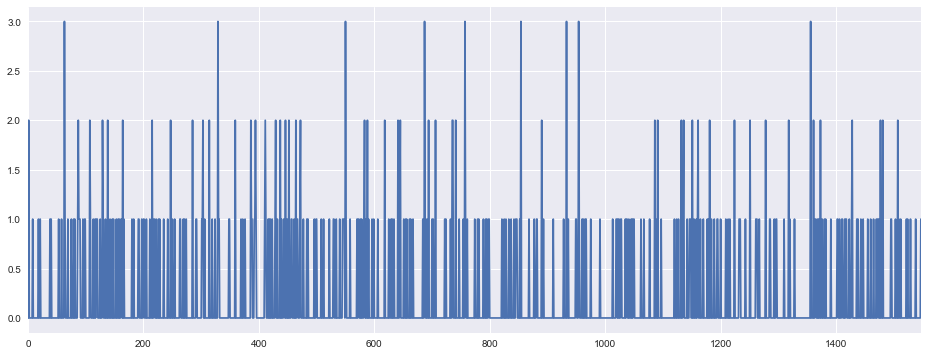

In [39]:
df['trust'].plot(figsize=(16, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x114373198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1146d1a58>], dtype=object)

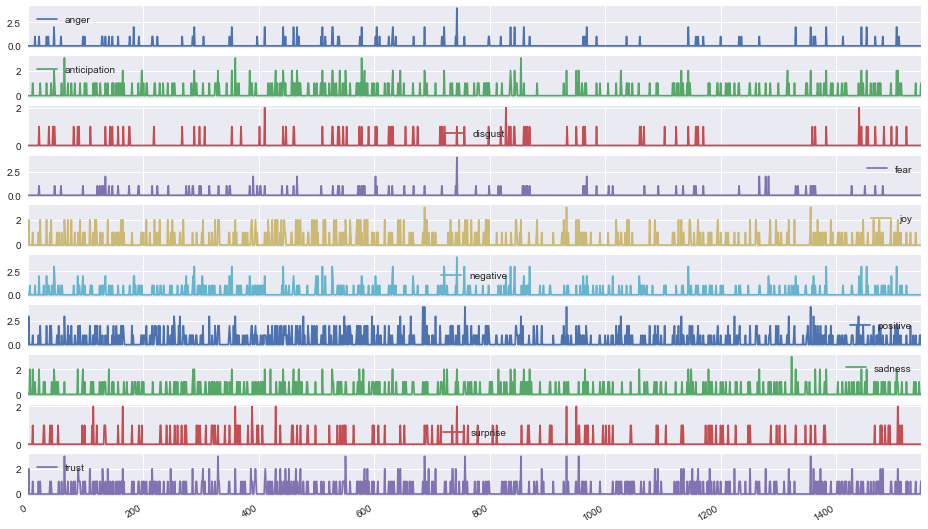

In [40]:
df.plot(subplots=True, figsize=(16, 10))

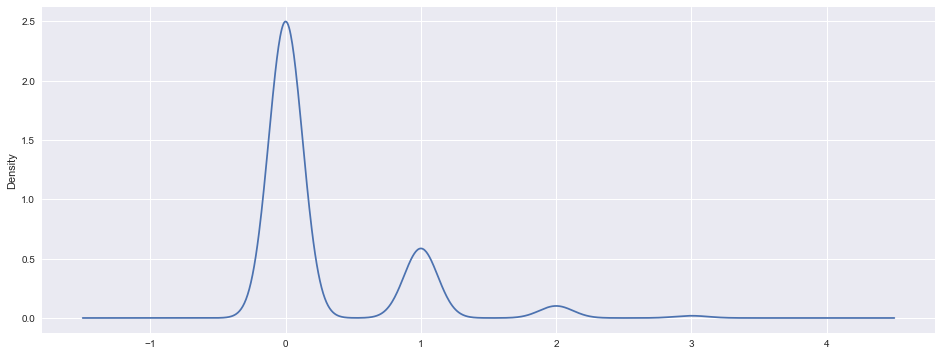

In [41]:
df['trust'].plot.kde(figsize=(16, 6))

In [43]:
df.sum()

tweet           Vote 4 John H Cox 4 #CAGov Lets turn CA all RE...
anger                                                         120
anticipation                                                  297
disgust                                                        95
fear                                                          108
joy                                                           406
negative                                                      344
positive                                                      614
sadness                                                       336
surprise                                                      153
trust                                                         408
dtype: object

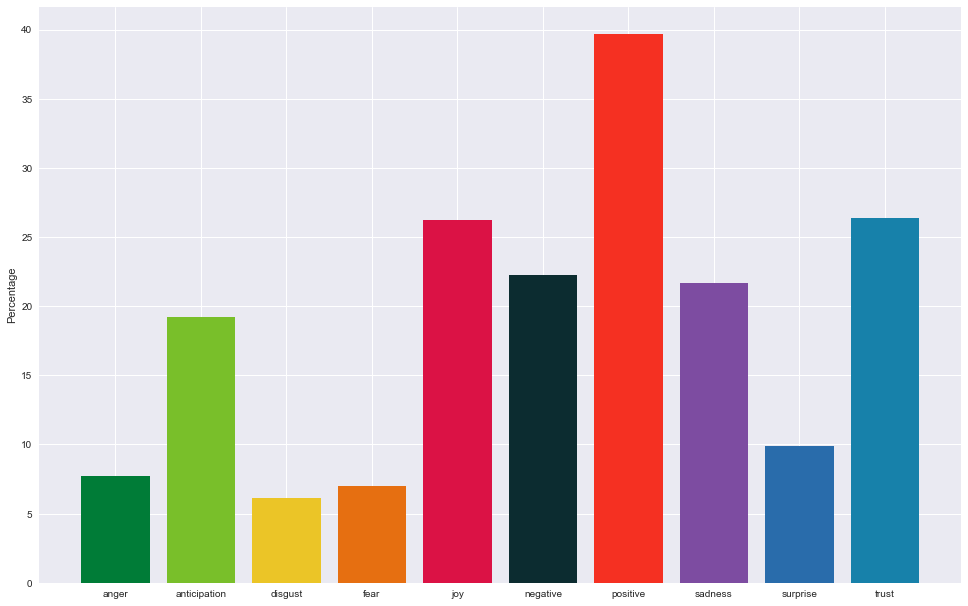

In [48]:
fig = plt.figure(figsize=(16, 10))
y_pos = np.arange(len(emotions))
percentage = df[emotions].sum()/len(df)*100
percentage = percentage.tolist()

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
colors = ["#007C37","#79BF2A","#EBC527","#E66F11","#DB1245","#0C2C30","#F53022","#7D4CA1","#296CAB","#1781AA"]
bars = ax.bar(y_pos, percentage, align='center')
for bar,c in zip(bars,colors):
    bar.set_facecolor(c)

plt.xticks(y_pos, emotions)
plt.ylabel('Percentage')

In [44]:
cor = df.corr()
cor

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
anger,1.000000,0.365157,0.506145,0.501966,0.058073,0.664673,0.055672,0.456228,0.097249,0.089732
anticipation,0.365157,1.000000,0.177677,0.131297,0.617743,0.223845,0.575675,0.233815,0.243140,0.522471
disgust,0.506145,0.177677,1.000000,0.301815,-0.008650,0.618289,-0.009502,0.291204,-0.011408,0.072098
fear,0.501966,0.131297,0.301815,1.000000,0.037593,0.416117,0.095065,0.321911,0.129501,0.126652
joy,0.058073,0.617743,-0.008650,0.037593,1.000000,-0.031620,0.840555,0.023149,0.197098,0.743312
negative,0.664673,0.223845,0.618289,0.416117,-0.031620,1.000000,-0.021924,0.633363,0.256877,0.053953
positive,0.055672,0.575675,-0.009502,0.095065,0.840555,-0.021924,1.000000,0.030783,0.180880,0.749628
sadness,0.456228,0.233815,0.291204,0.321911,0.023149,0.633363,0.030783,1.000000,0.327330,0.063654
surprise,0.097249,0.243140,-0.011408,0.129501,0.197098,0.256877,0.180880,0.327330,1.000000,0.217169
trust,0.089732,0.522471,0.072098,0.126652,0.743312,0.053953,0.749628,0.063654,0.217169,1.000000


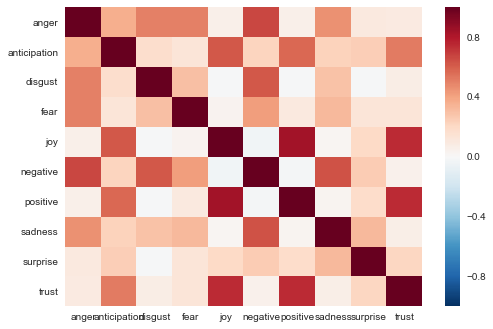

In [45]:
sns.heatmap(cor)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


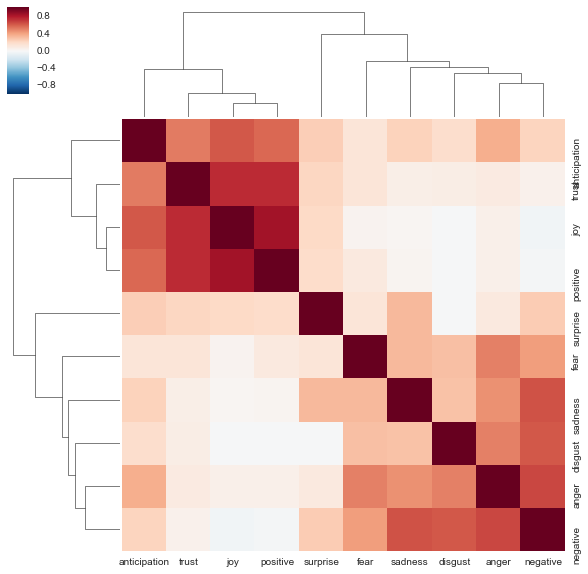

In [46]:
sns.clustermap(cor)

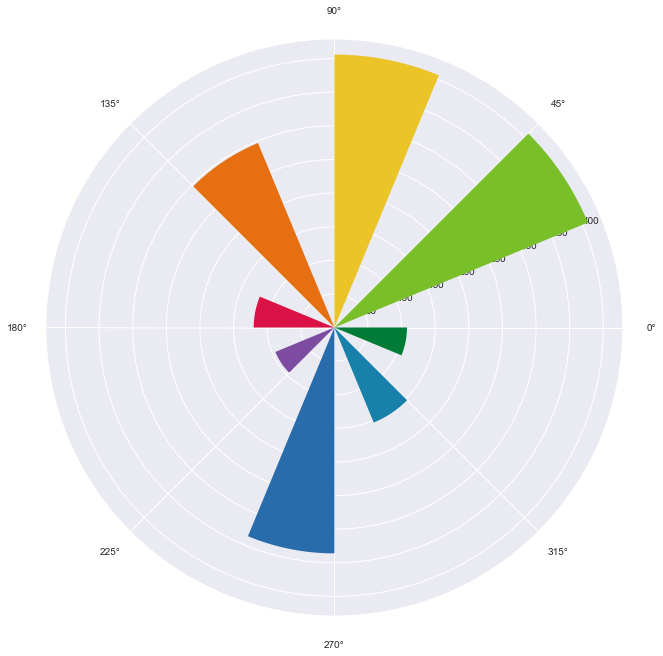

In [47]:
from matplotlib.pyplot import figure, show, rc

fig = figure(figsize=(10, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

colors = ['#007C37','#79BF2A','#EBC527','#E66F11','#DB1245','#7D4CA1','#296CAB','#1781AA']

N = 8
theta = np.arange(0, 2*np.pi, 2*np.pi/N)-(np.pi/(2*N))
radii = df[['fear','trust','joy','anticipation','anger','disgust','sadness','surprise']].sum()
width = np.pi/N
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar,c in zip(radii,bars,colors):
    bar.set_facecolor(c)
    bar.set_alpha(1)

show()

### Where else has this been used?

- Client interaciton.
- Sexual differences in comunication: http://dl.acm.org/citation.cfm?id=2107662
- Children's bedtime stories: http://www.musicfromtext.com/
- Mercutio: http://mercutio.albertobarradas.com/

### Where can it be used?
Generalization: Dictionary based lexical analysis. 
- Colors: http://www.lexichrome.com/#palette

Correlation with other variables.
- Correlating with digital profiles: Personality
- Correlating with digital activity: Motivation
- Correlating with physical data: Behaviour